# CA684 Machine Learning Assignment Spring 2022

# Getting Started

## Libraries

In [1]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib
from random import choices
from itertools import chain
import seaborn as sns
# Levenshtein Distance in Python
# https://github.com/seatgeek/thefuzz
!pip install thefuzz
!pip install wordcloud
from thefuzz import fuzz, process
from wordcloud import WordCloud, STOPWORDS
!pip install keras_preprocessing
!pip install tensorflow --ignore-installed --user
!pip install imgaug
!pip install natsort 
!pip install sklearn 
!pip install tqdm 
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import imgaug.augmenters as iaa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# this is an important module to use to serialize the image names in proper sorted order
from natsort import natsorted

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from tqdm import tqdm
# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

C:\ProgramData\Anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
Processing c:\users\mishr\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501\termcolor-1.1.0-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp38-cp38-win_amd64.whl (1.5 MB)
  Using cached h5py-3.6.0-cp38-cp38-win_amd64.whl (2.8 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached grpcio-1.44.0-cp38-cp38-win_amd64.whl (3.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-13.0.0-py2.py3-none-win_amd64.whl (13.9 MB)
  Using cached numpy-1.22.3-cp38-cp38-win_amd64.whl (14.7 MB)
  Using cached six-1.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\mishr\\AppData\\Roaming\\Python\\Python38\\site-packages\\numpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Check the permissions.




  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth-2.6.2-py2.py3-none-any.whl (156 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached Werkzeug-2.1.0-py3-none-any.whl (224 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached importlib_metadata-4.11.3-py3-none-any.whl (18 kB)
  Using c

### Set random seed

In [2]:
np.random.seed(seed=42)

## Dataset Description

The dataset will contain files as follows. 

* Two files containing **offers of products**, for training and testing respectively. An offer is a particular description of a product by an online shop, either Zalando or one of its competitors. They contains the following fields:

| Label | Description |
|:-----:|:------------|
| offer_id | unique identifier for an offer of a product (i.e. a product x shop combination, where we don’t know the product component) |
| shop | "zalando", "aboutyou" |
| lang | "de" (German) |
| brand | e.g. "Nike" - note that different `shop`s might have different `brand` nomenclature |
| color | e.g. "blue" - note that there could be more than one and different `shop`s might have different `brand` nomenclature ("ocean", "light blue", "...") and may have more than one color (ordering matters) |
| title | e.g. "White Nike tennis top" |
| description | a long product description that can may contain material composition, cleaning instructions, etc |
| price | price in euro without any discount |
| url | url of the product description page |
| image_urls | list of product images such as stock photo, with model, lifestyle photo, or close up |

* A separate file containing the **matches** in between those offers that describe the same products using the offer id. Note this is only provided for the training offers.

| Label | Description |
|:-----:|:------------|
| zalando | offer_id from “zalando” shop |
| aboutyou | offer_id from “aboutyou” shop |
| brand | unique identifier for the brand representing the match |

### Reading the training dataset

In [3]:
offers_training_df = pd.read_parquet('offers_training.parquet')

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the matching task!

### Number of Records or rows in training datatset

In [4]:
f'Number of products in training: {len(offers_training_df):,}'

'Number of products in training: 102,884'

### All columns in Training dataset

In [5]:
cols = list(offers_training_df.columns)
print('All columns = ',cols)

All columns =  ['offer_id', 'shop', 'lang', 'brand', 'color', 'title', 'description', 'price', 'url', 'image_urls']


### Sample View of dataset

In [6]:
offers_training_df.head(5)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...
3,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...
4,48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...


### function to print unique values

In [7]:
def UniqueValues(df,col):
    print('All columns = ',list(df[col].unique()))

### Unique values for columns shop and lang

In [8]:
for i in ['shop', 'lang']:
    UniqueValues(offers_training_df,i)

All columns =  ['aboutyou', 'zalando']
All columns =  ['de']


In [9]:
### Count Plot function

In [10]:
def CountPlot(df,col,l=15,b=5):
    figure, ax = plt.subplots(figsize=(l, b))
    # count plot on single categorical variable
    sns.countplot(x =col, data = df)
    plt.title('Total count of each category in '+col+' column')
    plt.ylabel('Number of products')
    plt.show()

### Value counts for shop

aboutyou    61980
zalando     40904
Name: shop, dtype: int64


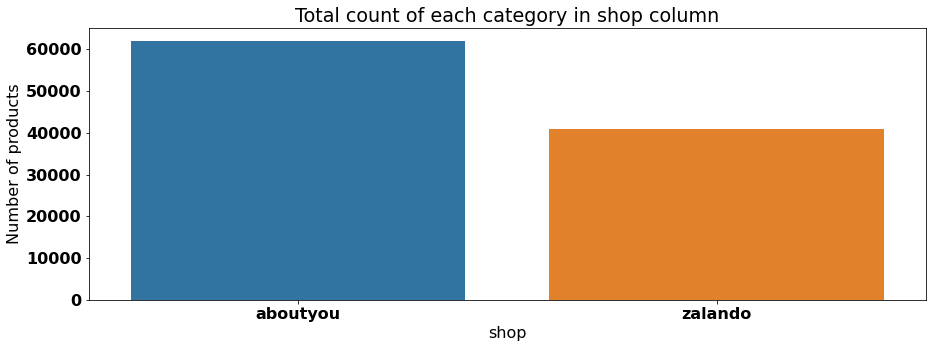

In [11]:
print(pd.value_counts(offers_training_df['shop'], sort=True, ascending=False))
CountPlot(offers_training_df,'shop')

### Description cleaning

In [12]:
def DesciptionValueCleaning(x):
    Description = []
    z = x.split(',')
    for i in z:
        Description.append(i.split(':'))
    Description_temp = {}
    for i in Description:
        
        try:
            #print(i[1])
            z1 = re.sub(r'\W+', '', i[0])
            z2 = re.sub(r'\W+', '', i[1])
            Description_temp[z1] = z2
            #print(z1 + ':'+ z2)
        except:
            Description_temp[re.sub(r'\W+', '', i[0])] = None
    
    
    return Description_temp

offers_training_df['description_split'] = offers_training_df['description'].apply(lambda x: x.split(","))
#print(offers_training_df['description_split'])
description_split_dict = offers_training_df['description'].apply(DesciptionValueCleaning)
offers_training_df['description_split'] = description_split_dict
#description_split_dict

In [13]:
all_indexes = []
regex = re.compile('[a-zA-Z_-]+$')
for i in description_split_dict:
    for j in i:
        #print(j)
        if(regex.match(j)):
            if j not in all_indexes:
                all_indexes.append(j)
all_indexes[:10]

['Material',
 'Ausschnitt',
 'Marke',
 'Passform',
 'Zielgruppe',
 'QuickFilterStyleGroup',
 'Suchfarbe',
 'Detailfarbe',
 'Ordersaison',
 'Muster']

### Selecting Data which can help in Matching

In [14]:
new_cols = ['Material','Business','Design','Stylegroup','Description','Supplier','Details']
def GettingValuesFromDict(x,y):
    try:
        return(x[y])
    except:
        return None
for i in new_cols:
    offers_training_df[i] = offers_training_df['description_split'].apply(GettingValuesFromDict,y=i)

In [15]:
offers_training_df.head(5)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls,description_split,Material,Business,Design,Stylegroup,Description,Supplier,Details
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...,"{'Material': 'Baumwolle', 'u00c4rmellu00e4nge'...",Baumwolle,Freizeit,Rippstrick,trend,RundhalsausschnittnDehnbaresgeripptesMaterialn...,None,None
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...,"{'Leibhu00f6he': 'SuperLowWaist', 'Marke': 'LA...",None,None,AbgesteppterSaumKante,modern,tableclasstmpArticleDetailTablecaptionbProdukt...,Otto,None
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...,"{'Marke': 'MAMALICIOUS', 'Gru00f6u00dfenlauf':...",None,None,None,None,,None,None
3,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...,"{'Marke': 'rosemunde', 'Zielgruppe': 'Female',...",Polyester,None,None,modern,,None,None
4,48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...,"{'u00c4rmellu00e4nge': 'Langarm', 'Ausschnitt'...",Viskose,Freizeit,Knopfleiste,trend,VAusschnittnDurchgehendeKnopfleistevornnBindeg...,None,None


### All Unique Colors Count

In [16]:
unique_colors = []
for i in offers_training_df['color']:
    try:
        color = i.split('|')
        for j in color:
            if j.strip().lower() not in unique_colors:
                unique_colors.append(j.strip().lower())
                #print(j.strip())
    except:
        pass
    
print('Total Unique Colors in the dataset = ',len(unique_colors))

Total Unique Colors in the dataset =  258


### Top 5 colors in all products

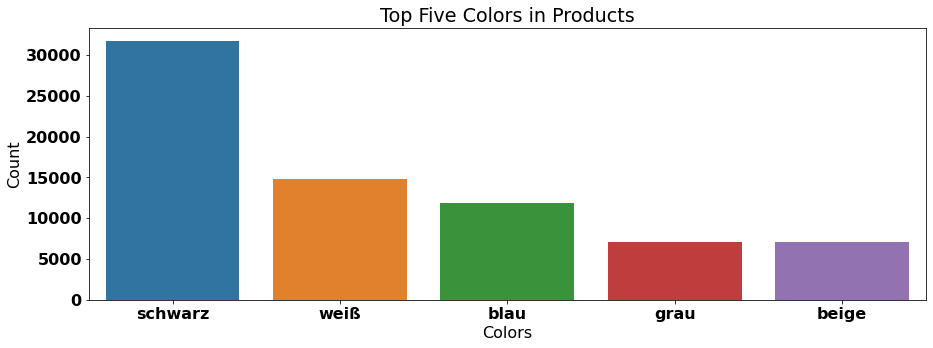

In [17]:
def ColorSplit(x):
    try:
        y = []
        x = x.split('|')
        for i in x:
            y.append(i.strip().lower())
        return list(set(y))
    except:
        return []
offers_training_df['color_split'] = offers_training_df['color'].apply(ColorSplit)
#offers_training_df['color_split']
colorcount = {}
for i in unique_colors:
    count = 0
    for j in offers_training_df['color_split']:
        for k in j:
            if i == k:
                count += 1
    colorcount[i] = count
colorcount_df = pd.DataFrame(list(colorcount.items()),columns = ['Color','Count'])
colorcount_df = colorcount_df.sort_values('Count', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'Color',
            y = 'Count',
            data = colorcount_df[:5])
plt.title('Top Five Colors in Products')
plt.xlabel('Colors')
plt.show()

### WordCloud of Colors

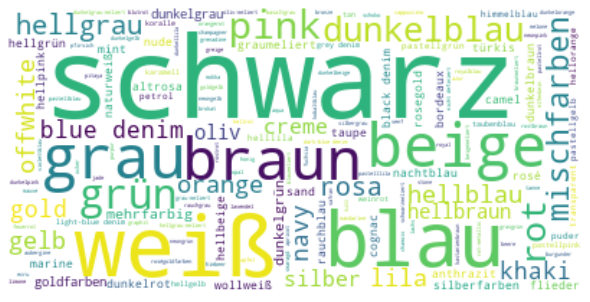

In [18]:
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate_from_frequencies(frequencies=colorcount)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

### Top 5 Titles or Products

Total Unique Titles in the dataset =  36879


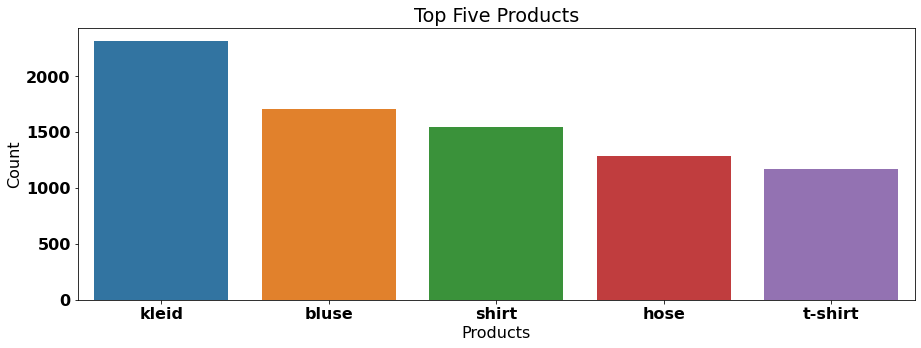

In [19]:
unique_titles = []
for i in offers_training_df['title']:
    try:
        title = i.split('/')
        for j in title:
            if j.strip().lower() not in unique_titles:
                unique_titles.append(j.strip().lower())
                #print(j.strip())
    except:
        pass
    
print('Total Unique Titles in the dataset = ',len(unique_titles))


def TitleSplit(x):
    try:
        y = []
        x = x.split('/')
        for i in x:
            y.append(i.strip().lower())
        return y
    except:
        return []
offers_training_df['title_split'] = offers_training_df['title'].apply(TitleSplit)
#offers_training_df['title_split']
titlecount = {}
for i in unique_titles:
    count = 0
    for j in offers_training_df['title_split']:
        for k in j:
            if i == k:
                count+= 1
    titlecount[i] = count
titlecount_df = pd.DataFrame(list(titlecount.items()),columns = ['Title','Count'])
titlecount_df = titlecount_df.sort_values('Count', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'Title',
            y = 'Count',
            data = titlecount_df[:5])
plt.title('Top Five Products')
plt.xlabel('Products')
plt.show()

### WordCloud of Title

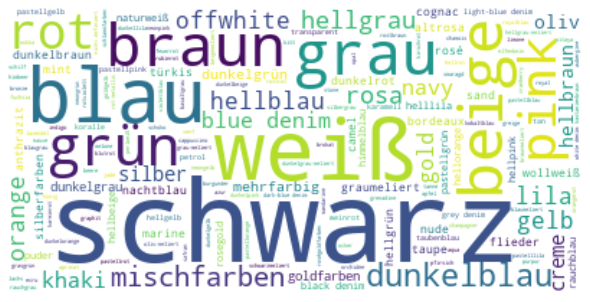

In [20]:
wordcloud.generate_from_frequencies(frequencies=colorcount)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

### Total Unique Brands

In [21]:
def BrandsCleaning(x):
    return x.strip().lower()
offers_training_df['brand_new'] = offers_training_df['brand'].apply(BrandsCleaning)
unique_brands = offers_training_df['brand_new'].unique()
print('Total Unique Brands = ',len(unique_brands))

Total Unique Brands =  109


### Top 5 brands with highest number of products

           brand_new
vero moda      20877
guess           9203
pieces          8729
lascana         5535
ellesse         3115


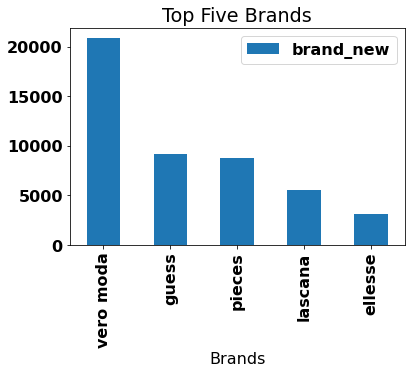

In [22]:
brand_count_df = pd.value_counts(offers_training_df['brand_new'], sort=True, ascending=False)[:5]
brand_count_df = brand_count_df.to_frame()
print(brand_count_df)
brand_count_df.plot.bar()
plt.title('Top Five Brands')
plt.xlabel('Brands')
plt.show()

### Histogram of Prices (Products under and equal to 300€)

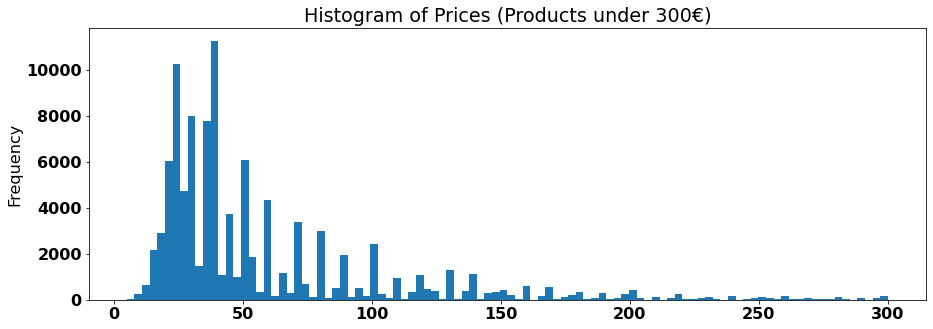

In [23]:
figure, ax = plt.subplots(figsize=(15, 5))
plt.title('Histogram of Prices (Products under 300€)')
offers_training_df[offers_training_df['price'] <= 300]['price'].plot.hist(bins=100)
plt.show()

### Histogram of Prices (Products above 300€)

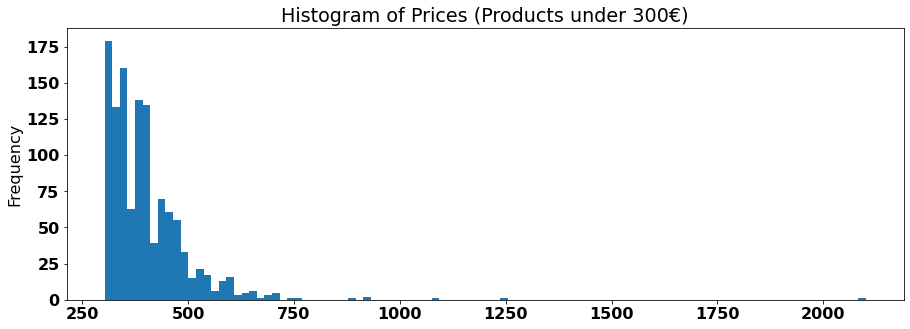

In [24]:
figure, ax = plt.subplots(figsize=(15, 5))
plt.title('Histogram of Prices (Products under 300€)')
offers_training_df[offers_training_df['price'] > 300]['price'].plot.hist(bins=100)
plt.show()

## New dataframe after adding new Columns

In [25]:
offers_training_df.head(5)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls,...,Material,Business,Design,Stylegroup,Description,Supplier,Details,color_split,title_split,brand_new
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...,...,Baumwolle,Freizeit,Rippstrick,trend,RundhalsausschnittnDehnbaresgeripptesMaterialn...,None,None,"[hellblau, blau]",[kleid],pieces
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...,...,None,None,AbgesteppterSaumKante,modern,tableclasstmpArticleDetailTablecaptionbProdukt...,Otto,None,"[schwarz, mischfarben]",[bikinihose],lascana
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...,...,None,None,None,None,,None,None,[beige],[chino-hose],mamalicious
3,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...,...,Polyester,None,None,modern,,None,None,"[pink, rosa]","[top, seidentop]",rosemunde
4,48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...,...,Viskose,Freizeit,Knopfleiste,trend,VAusschnittnDurchgehendeKnopfleistevornnBindeg...,None,None,"[schwarz, mischfarben]",[kleid],pieces


## Bivariate Ananlysis

### Description of Table

In [26]:
offers_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102884 entries, 0 to 102883
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   offer_id           102884 non-null  object 
 1   shop               102884 non-null  object 
 2   lang               102884 non-null  object 
 3   brand              102884 non-null  object 
 4   color              102882 non-null  object 
 5   title              102884 non-null  object 
 6   description        102884 non-null  object 
 7   price              102882 non-null  float64
 8   url                102884 non-null  object 
 9   image_urls         102858 non-null  object 
 10  description_split  102884 non-null  object 
 11  Material           32005 non-null   object 
 12  Business           13446 non-null   object 
 13  Design             31305 non-null   object 
 14  Stylegroup         42875 non-null   object 
 15  Description        59297 non-null   object 
 16  Su

### Total and average Price of products for each Shops

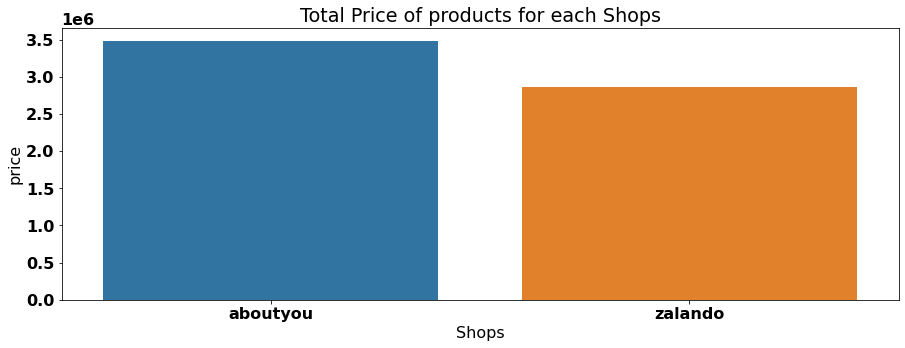

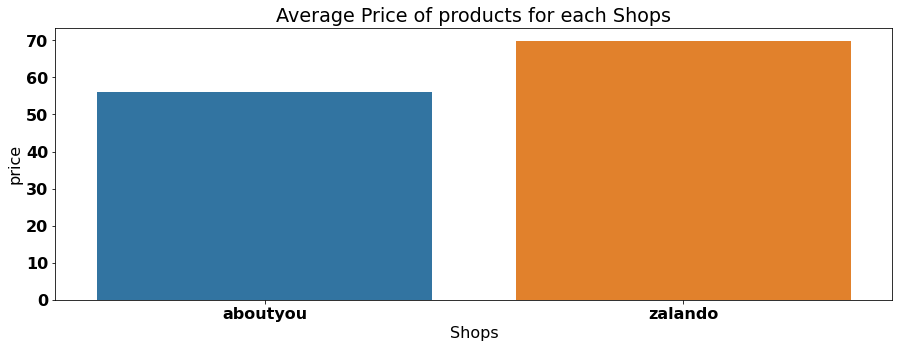

In [27]:
total_price_shop = offers_training_df.groupby(['shop']).sum(['price'])
total_price_shop.reset_index(inplace = True)
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'shop',
            y = 'price',
            data = total_price_shop)
plt.title('Total Price of products for each Shops')
plt.xlabel('Shops')
plt.show()
avg_price_shop = offers_training_df.groupby(['shop']).mean(['price'])
avg_price_shop.reset_index(inplace = True)
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'shop',
            y = 'price',
            data = avg_price_shop)
plt.title('Average Price of products for each Shops')
plt.xlabel('Shops')
plt.show()

### Top 5 Brands with highest Total and average Price

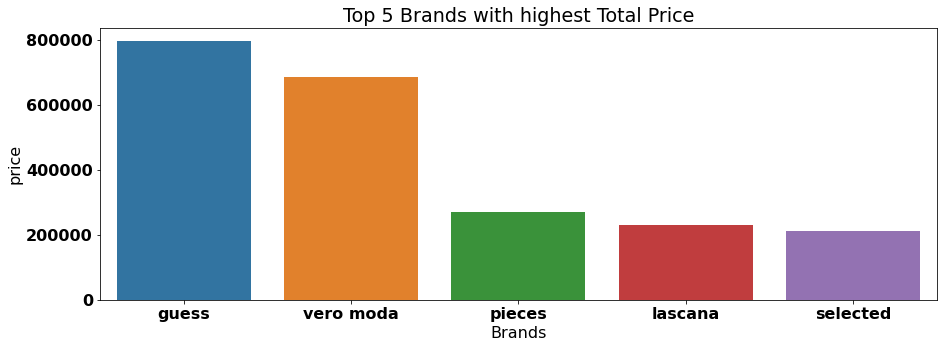

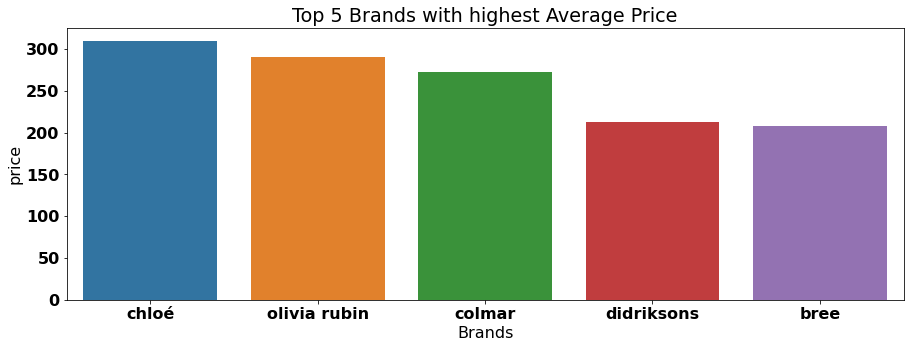

In [28]:
total_price_brands = offers_training_df.groupby(['brand_new']).sum(['price'])
total_price_brands.reset_index(inplace = True)
total_price_brands = total_price_brands.sort_values('price', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'brand_new',
            y = 'price',
            data = total_price_brands[:5])
plt.title('Top 5 Brands with highest Total Price')
plt.xlabel('Brands')
plt.show()
avg_price_brands = offers_training_df.groupby(['brand_new']).mean(['price'])
avg_price_brands.reset_index(inplace = True)
avg_price_brands = avg_price_brands.sort_values('price', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'brand_new',
            y = 'price',
            data = avg_price_brands[:5])
plt.title('Top 5 Brands with highest Average Price')
plt.xlabel('Brands')
plt.show()

### Top 5 Colors with highest Total and average Price

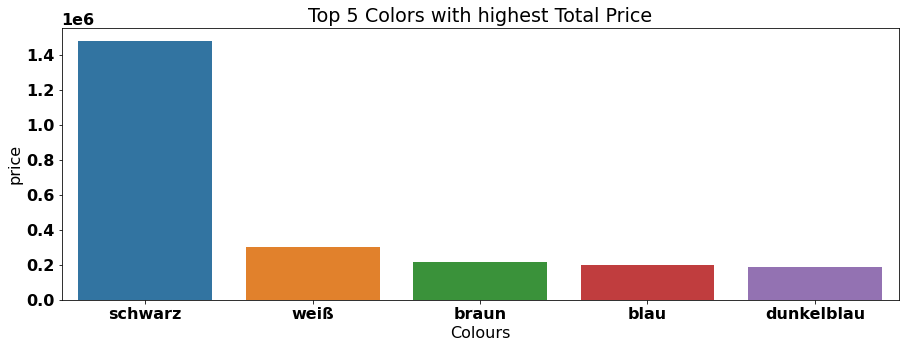

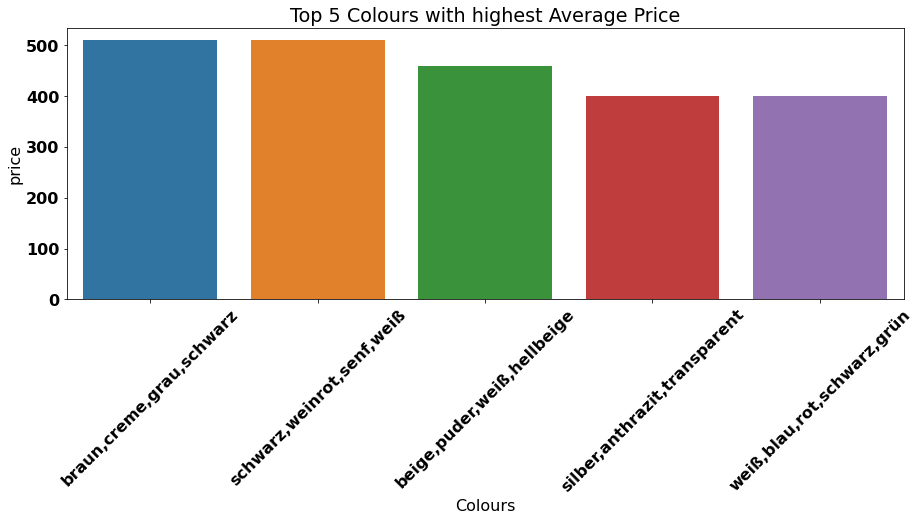

In [29]:
offers_training_df['color_new'] = offers_training_df['color_split'].apply(lambda x: ','.join(x))
total_price_colors = offers_training_df.groupby(['color_new']).sum(['price'])
total_price_colors.reset_index(inplace = True)
total_price_colors = total_price_colors.sort_values('price', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'color_new',
            y = 'price',
            data = total_price_colors[:5])
plt.title('Top 5 Colors with highest Total Price')
plt.xlabel('Colours')
plt.show()
avg_price_colors = offers_training_df.groupby(['color_new']).mean(['price'])
avg_price_colors.reset_index(inplace = True)
avg_price_colors = avg_price_colors.sort_values('price', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'color_new',
            y = 'price',
            data = avg_price_colors[:5])
plt.title('Top 5 Colours with highest Average Price')
plt.xlabel('Colours')
plt.xticks(rotation=45)
plt.show()

### Top 5 Titles with highest Total and average Price

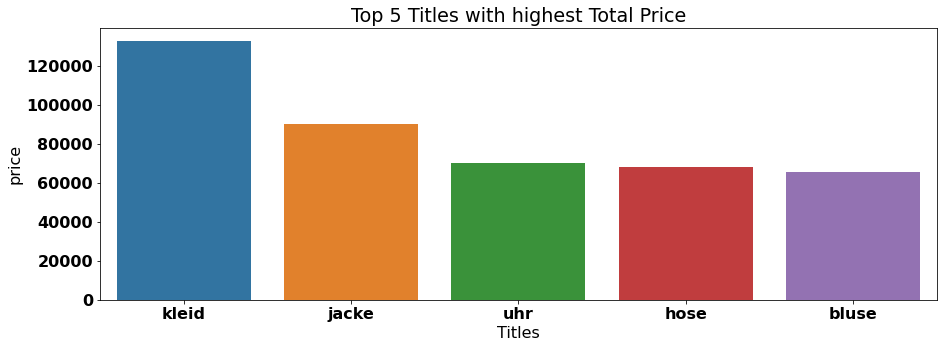

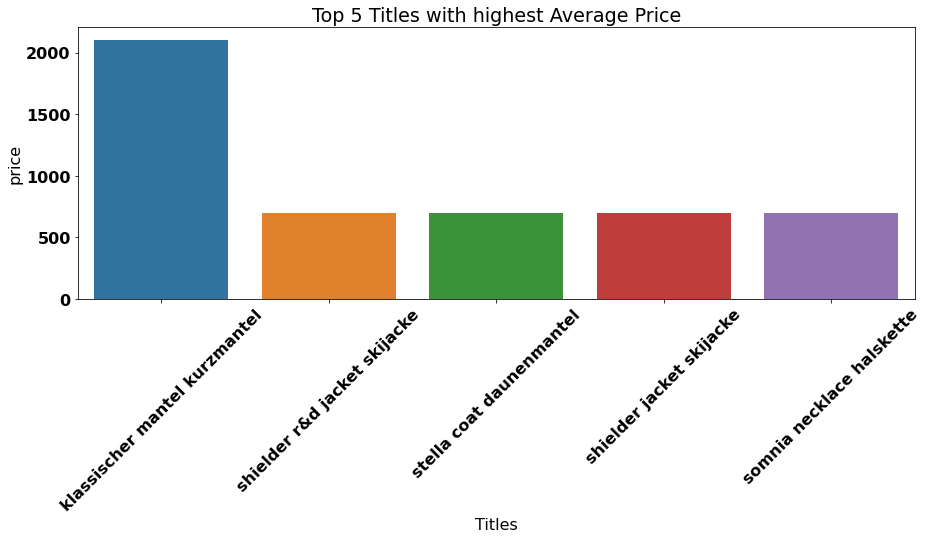

In [30]:
offers_training_df['title_new'] = offers_training_df['title_split'].apply(lambda x: ','.join(x))
total_price_titles = offers_training_df.groupby(['title_new']).sum(['price'])
total_price_titles.reset_index(inplace = True)
total_price_titles = total_price_titles.sort_values('price', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'title_new',
            y = 'price',
            data = total_price_titles[:5])
plt.title('Top 5 Titles with highest Total Price')
plt.xlabel('Titles')
plt.show()
avg_price_titles = offers_training_df.groupby(['title_new']).mean(['price'])
avg_price_titles.reset_index(inplace = True)
avg_price_titles = avg_price_titles.sort_values('price', ascending=[False])
figure, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = 'title_new',
            y = 'price',
            data = avg_price_titles[:5])
plt.title('Top 5 Titles with highest Average Price')
plt.xlabel('Titles')
plt.xticks(rotation=45)
plt.show()

## Now Reading Matching dataset

In [31]:
matches_training_df = pd.read_parquet('matches_training.parquet')
matches_training_df.head(5)

,zalando,aboutyou,brand
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,10
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,10


In [32]:
f"Number of unique brands in training matches: {len(matches_training_df['brand'].unique()):,}"

'Number of unique brands in training matches: 76'

### Function to plot images from the url

In [33]:
def plot_images(images):
    
    # Plot it!
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 4), dpi=100)
    
    if len(images) > 1:     
        axes = axes.flatten()
        for i, axis in enumerate(axes):
            url = images[i]
            image = np.array(Image.open(urllib.request.urlopen(url)))
            axis.imshow(image)
            axis.axis('off')
    else:
        url = images[0]
        image = np.array(Image.open(urllib.request.urlopen(url)))
        axes.imshow(image)
        axes.axis('off')

    fig.tight_layout()
    plt.show()

### Comparing Matched product by images

Product From Zalando:


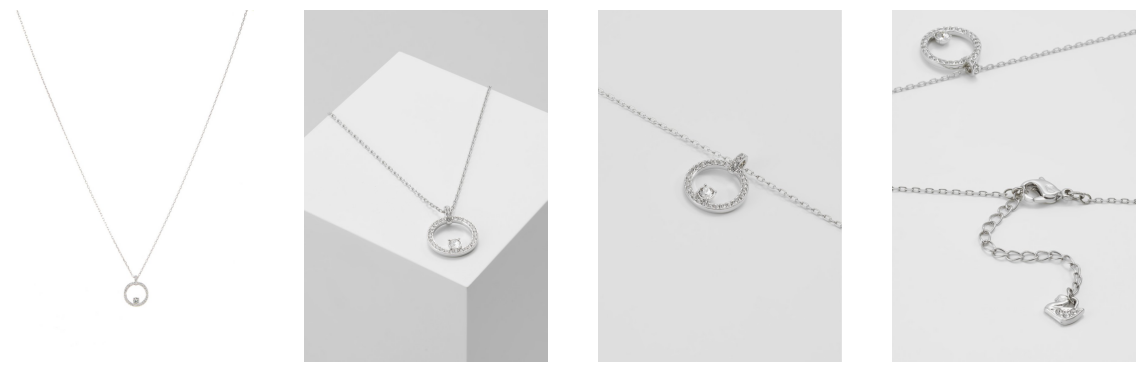

Product From aboutyou:


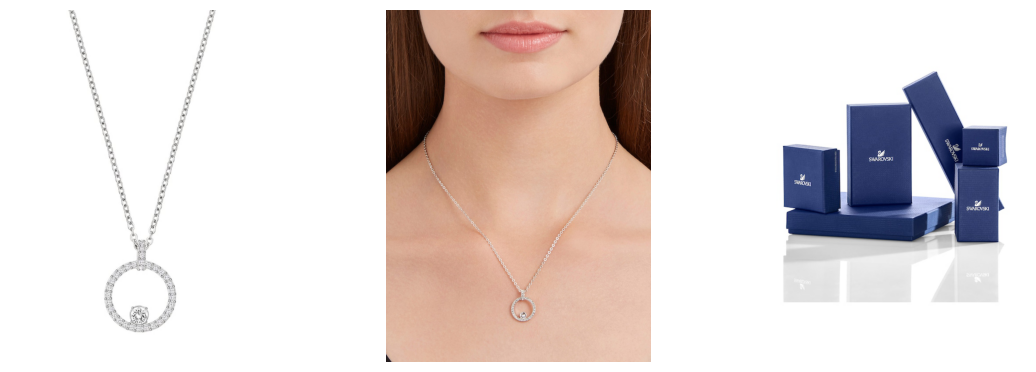

In [34]:
Matched_product = matches_training_df.iloc[0]
print("Product From Zalando:")
plot_images(offers_training_df[offers_training_df['offer_id'] == Matched_product[0]]['image_urls'].iloc[0])
print("Product From aboutyou:")
plot_images(offers_training_df[offers_training_df['offer_id'] == Matched_product[1]]['image_urls'].iloc[0])

Product From Zalando:


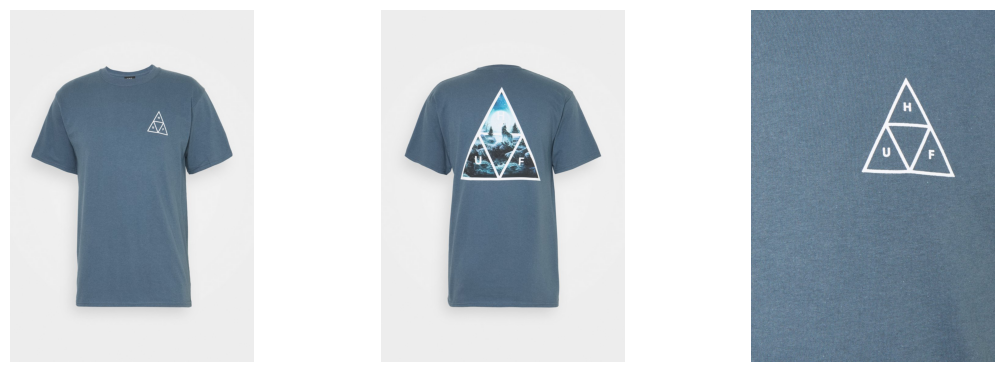

Product From aboutyou:


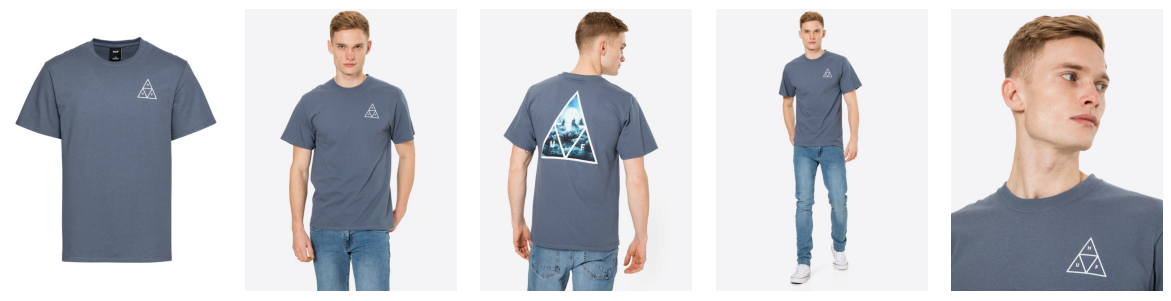

In [35]:
Matched_product = matches_training_df.iloc[25]
print("Product From Zalando:")
plot_images(offers_training_df[offers_training_df['offer_id'] == Matched_product[0]]['image_urls'].iloc[0])
print("Product From aboutyou:")
plot_images(offers_training_df[offers_training_df['offer_id'] == Matched_product[1]]['image_urls'].iloc[0])

Product From Zalando:


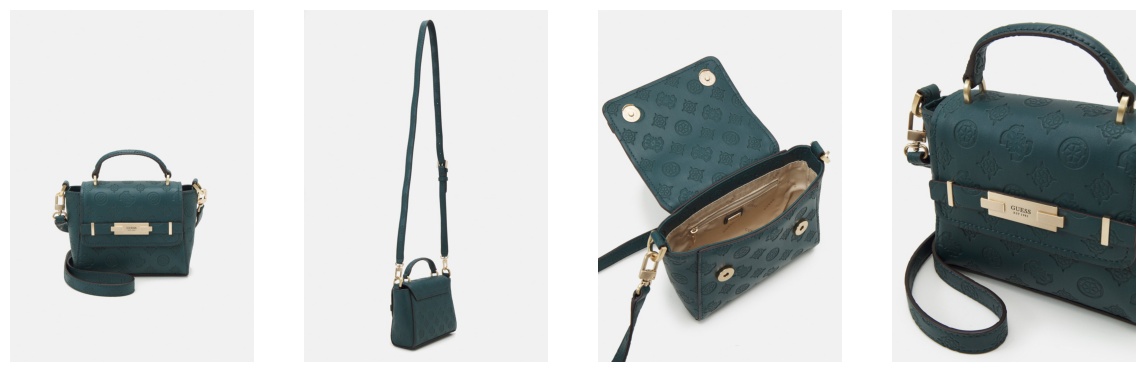

Product From aboutyou:


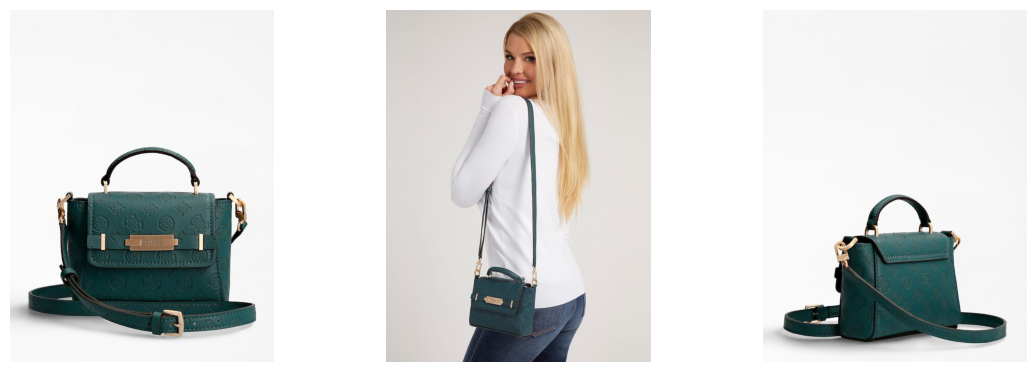

In [36]:
Matched_product = matches_training_df.iloc[500]
print("Product From Zalando:")
plot_images(offers_training_df[offers_training_df['offer_id'] == Matched_product[0]]['image_urls'].iloc[0])
print("Product From aboutyou:")
plot_images(offers_training_df[offers_training_df['offer_id'] == Matched_product[1]]['image_urls'].iloc[0])

# Product Matching Models:
## Title Similarity
## Price Comparison
## Attribute Extraction
## Image Similarity

In [37]:
offers_training_df.head(5)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls,...,Design,Stylegroup,Description,Supplier,Details,color_split,title_split,brand_new,color_new,title_new
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...,...,Rippstrick,trend,RundhalsausschnittnDehnbaresgeripptesMaterialn...,None,None,"[hellblau, blau]",[kleid],pieces,"hellblau,blau",kleid
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...,...,AbgesteppterSaumKante,modern,tableclasstmpArticleDetailTablecaptionbProdukt...,Otto,None,"[schwarz, mischfarben]",[bikinihose],lascana,"schwarz,mischfarben",bikinihose
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...,...,None,None,,None,None,[beige],[chino-hose],mamalicious,beige,chino-hose
3,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...,...,None,modern,,None,None,"[pink, rosa]","[top, seidentop]",rosemunde,"pink,rosa","top,seidentop"
4,48b32330-0a6e-4c10-9ef5-c585ac6da701,aboutyou,de,PIECES,mischfarben | schwarz | Mischfarben | Schwarz,Kleid,"{""\u00c4rmell\u00e4nge"": [""Langarm""], ""Ausschn...",39.90,https://www.aboutyou.at/p/pieces/kleid-5195289,[https://cdn.aboutstatic.com/file/images/c85d6...,...,Knopfleiste,trend,VAusschnittnDurchgehendeKnopfleistevornnBindeg...,None,None,"[schwarz, mischfarben]",[kleid],pieces,"schwarz,mischfarben",kleid


In [38]:
def MatchingDataframe(x,match_df,z):
    match_df.columns = ['zalando','offer_id','brand']
    temp_df = pd.merge(match_df,x,how='left',on="offer_id")
    temp_df.columns = ['offer_id','aboutyou','brand',z+'_aboutyou']
    temp_df = pd.merge(temp_df,x,how='left',on="offer_id")
    temp_df.columns = ['offer_id','aboutyou','brand',z+'_aboutyou',z+'_zalando']
    return temp_df
    

In [39]:
x = MatchingDataframe(offers_training_df[['offer_id','brand_new']],matches_training_df,'brand')
x

,offer_id,aboutyou,brand,brand_aboutyou,brand_zalando
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10,swarovski,swarovski
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10,swarovski,swarovski
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10,swarovski,swarovski
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,10,swarovski,swarovski
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,10,swarovski,swarovski
...,...,...,...,...,...
15165,29ffe4d1-c298-473c-a6da-b568e2a828c0,c0595145-bf4c-4d86-86e1-dfb4b07da767,77,guess,guess
15166,b5c8c045-0185-4515-95f9-ad10a65026fc,d515e41e-f680-45e1-a029-0650ac8cf20e,77,guess,guess
15167,cd874fd4-a2d6-4e02-a5b5-514f68148027,4ab54165-938d-43df-9f3e-48da066c873d,77,guess,guess
15168,92a6d277-d460-42c5-bc12-343dd800f40a,8992e0b1-3a27-4e3e-be9a-42c014826a38,77,guess,guess


# Title Similarity

## Brand similarity

### Number of records where Both shops have same brand name matched

In [40]:
Matched_brand = x[x['brand_aboutyou'] == x['brand_zalando']]
print('Number of Matched Brand name records = ',len(Matched_brand))
Matched_brand.head(5)

Number of Matched Brand name records =  10708


,offer_id,aboutyou,brand,brand_aboutyou,brand_zalando
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10,swarovski,swarovski
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10,swarovski,swarovski
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10,swarovski,swarovski
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,10,swarovski,swarovski
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,10,swarovski,swarovski


### Number of records where Both shops have different brand name

In [41]:
NotMatched_brand = x[x['brand_aboutyou'] != x['brand_zalando']]
print('Number of Matched Brand name records = ',len(NotMatched_brand))
NotMatched_brand.head(5)

Number of Matched Brand name records =  4462


,offer_id,aboutyou,brand,brand_aboutyou,brand_zalando
32,b2c14810-79a2-48cf-a288-39e806f51572,86e5df24-6b18-4d3d-81b7-c4a64488be80,10,vivance,lascana
51,6309d6e7-15c2-4700-94b5-032175b51132,e75a31c6-d679-408c-95e0-b6bac176571f,158,pieces tall,pieces
52,d70908a6-05b1-456b-a772-6176e1cd5380,3708672a-5986-4673-a89b-c10e48cf0701,158,pieces curve,pieces
55,76c6c0a9-26f2-4111-b83f-f607ecfd4d33,c9b13c5d-5b78-4cc0-a280-169f6725bbfd,718,selected femme,selected
56,97763dd5-f220-4352-87f3-5edb9f98918a,cfbd0cac-a8b2-48f0-9c96-b8a87a090638,718,selected femme,selected


## Functions for Matching products

In [42]:
brands_training = offers_training_df['brand'].unique()
offers_test_df = pd.read_parquet('offers_test.parquet')
brands_test = offers_test_df['brand'].unique()
matches_training_df = pd.read_parquet('matches_training.parquet')

In [43]:
def get_shops_for_brand(offers, brands):
    """ Get mapping for brands in between the two shops """
    
    mapping = {}
    for brand in brands:
        shops = offers[offers["brand"] == brand]["shop"].unique()
        for shop in shops:
            mapping.setdefault(shop, [])
            mapping[shop].append(brand)
        print(f'Brand: "{brand}" is in {", ".join(shops)}')
    return mapping

In [44]:
def get_offers_by_shop(offers, mapping):
    """ Get offers per shop """
    
    offers_zal = offers[
        (offers['shop'] == 'zalando') & 
        (offers['brand'].isin(mapping['zalando']))
    ]
    offers_comp = offers[
        (offers['shop'] == 'aboutyou') &
        (offers['brand'].isin(mapping['aboutyou']))
    ]
    return offers_zal, offers_comp

In [45]:
def get_features(offers):
    """ Extract some text features using title and color """
    
    offers['text'] = offers[
        ['title_new','color_new']
    ].apply(lambda x : f"{x[0]} {x[1].split('|')[0]}", axis=1)
    
    return offers[['offer_id', 'text']].values

In [46]:
def dummy_matcher(zal_offers, comp_offers, brand_block_index):
    """
    Slow and dummy matcher that matches each Zalando offer to an AboutYou offer 
    Note: there is no need to match all offers as not all of them can be matched
    """
    
    # Get text from offers
    comp_text = comp_offers[:, 1]
    choices_dict = {idx: el for idx, el in enumerate(comp_text)}
    
    predicted_matches = []

    # For each zalando offer
    for zal_offer_id, zal_text in zal_offers:
        
        # Extract the best match using TheFuzz's package
        title, score, index = process.extractOne(zal_text, choices_dict) 
        comp_offer_id = comp_offers[index][0]

        # Add predicted match
        predicted_matches.append(
            {
                'zalando': zal_offer_id,
                'aboutyou': comp_offer_id,
                'brand': brand_block_index
            }
        )

    return pd.DataFrame(predicted_matches)

In [47]:
def get_brand_predictions(brand_pattern, brand_unique_index):
    """ 
    Custom pipeline to get the brand mapping, offers per shop, extract the features and generate predictions
    """

    list_brands = [
        brand
        for brand in brands_training
        if brand_pattern in brand.lower()
    ]

    # Get brand mapping
    brand_mapping = get_shops_for_brand(offers_training_df, list_brands)
    print(f'Mapping: {brand_mapping}')

    # Get offers
    brand_offers_zal, brand_offers_comp = get_offers_by_shop(offers_training_df, brand_mapping)
    
    print(f'Number of "{brand_pattern}" products: {len(brand_offers_zal) + len(brand_offers_comp):,} (' + \
          f'Zalando: {len(brand_offers_zal):,} ' + \
          f'and AboutYou: {len(brand_offers_comp):,})')

    # Get features
    brand_offers_zal_features = get_features(brand_offers_zal)
    brand_offers_comp_features = get_features(brand_offers_comp)

    # Match!
    predictions = dummy_matcher(
        brand_offers_zal_features, 
        brand_offers_comp_features, 
        brand_unique_index
    )
    
    print(f'Number of predicted matches for "{brand_pattern}": {len(predictions):,}')
    
    return brand_offers_zal, brand_offers_comp, predictions

In [48]:
quiksilver_offers_zal, quiksilver_offers_comp, quiksilver_predicted_matches = get_brand_predictions('burberry', 1)

Brand: "BURBERRY" is in aboutyou
Brand: "Burberry" is in zalando
Mapping: {'aboutyou': ['BURBERRY'], 'zalando': ['Burberry']}
Number of "burberry" products: 724 (Zalando: 110 and AboutYou: 614)
Number of predicted matches for "burberry": 110


In [49]:
quiksilver_offers_zal, quiksilver_offers_comp, quiksilver_predicted_matches = get_brand_predictions('quiksilver', 0)

Brand: "QUIKSILVER" is in aboutyou
Brand: "Quiksilver" is in zalando
Mapping: {'aboutyou': ['QUIKSILVER'], 'zalando': ['Quiksilver']}
Number of "quiksilver" products: 847 (Zalando: 506 and AboutYou: 341)
Number of predicted matches for "quiksilver": 506


In [50]:
veja_offers_zal, veja_offers_comp, veja_predicted_matches = get_brand_predictions('veja', 2)

Brand: "Veja" is in zalando, aboutyou
Mapping: {'zalando': ['Veja'], 'aboutyou': ['Veja']}
Number of "veja" products: 260 (Zalando: 243 and AboutYou: 17)
Number of predicted matches for "veja": 243


## Evaluation

Now that we just learned some mapping between the offers and the matches, we can evaluate the performance of our matching algorithm. In a qualitative way, we can explore the matches using the actual images as we can quickly figure out whether that is actually a match or not. In a quantitative manner, we can measure its performance leveraging F1, precision and recall metrics after calculating the confusion matrix between actual matches and the predicted ones. 

The goal of the assignment is to maximize F1 overall!

In [51]:
def explore_match(match):
    """ Explore a match with the offers' images """
    
    # get offer ids
    zal_offer_id = match['zalando']
    comp_offer_id = match['aboutyou']
    
    # get offers
    zalando_offer = offers_training_df[offers_training_df['offer_id'] == zal_offer_id].iloc[0]
    comp_offer = offers_training_df[offers_training_df['offer_id'] == comp_offer_id].iloc[0]
    
    # show images and text
    print(f"Zalando: {zalando_offer['title']} {zalando_offer['color']}")
    plot_images(zalando_offer)
    print(f"AboutYou: {comp_offer['title']} {zalando_offer['color']}")
    plot_images(comp_offer)
    
    
def get_true_matches_brand(zal_offers):
    """ Get true matches based on their brand block """
    
    # get brand block / mapping index from the training matches
    indexes = zal_offers.merge(
        matches_training_df,
        left_on='offer_id',
        right_on='zalando',
        suffixes=['offer', 'match']
    )['brandmatch'].unique()
    
    return matches_training_df[matches_training_df['brand'].isin(indexes)]


def get_metrics(true_matches, predicted_matches, offers_comp):
    """ Calculate performance metrics """
    
    # True Positives
    TP = len(
        true_matches.merge(
            predicted_matches, 
            on=['zalando', 'aboutyou'], 
            how='inner', 
        )
    )
    
    # False Negatives
    FN = len(true_matches) - TP
    
    # Actual Positives
    positives = len(true_matches)
    assert positives == TP + FN
    
    # Actual Negatives (with respect to the competitor)
    negatives = len(offers_comp) - positives
    
    # Actual negative values (with respect to the competitor)
    offers_comp_with_matches = offers_comp.merge(
        true_matches, 
        left_on='offer_id',
        right_on='aboutyou',
        how='outer',
        indicator=True
    )
    negative_values = offers_comp_with_matches[
        offers_comp_with_matches['_merge'] == 'left_only'
    ]['offer_id'].unique()
    
    assert negatives == len(negative_values)
    
    # Competitor predictions
    comp_preds = predicted_matches['aboutyou'].unique()
    
    # False Negatives (with respect to the competitor)
    FP = len(np.intersect1d(negative_values, comp_preds))
    
    # True Negatives
    TN = negatives - FP
    
    # Precision, Recall and F1 metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 0
    if precision + recall > 0:
        F1 = 2 * precision * recall / (precision + recall)
    
    metrics = dict(
        TP=TP,
        FN=FN,
        FP=FP,
        TN=TN,
        positives=positives,
        negatives=negatives,
        precision=precision,
        recall=recall,
        F1=F1,
    )
        
    return metrics

def get_brand_metrics(brand_offers_zal, brand_offers_comp, brand_predicted_matches):

    # Get groundtruth
    brand_true_matches = get_true_matches_brand(brand_offers_zal)
    
    print(f'Number of true matches: {len(brand_true_matches):,}')

    # Get metrics
    brand_metrics = get_metrics(brand_true_matches, brand_predicted_matches, brand_offers_comp)
    
    return brand_true_matches, brand_metrics

In [52]:
quiksilver_true_matches, quiksilver_metrics = get_brand_metrics(
    quiksilver_offers_zal, quiksilver_offers_comp, quiksilver_predicted_matches)
quiksilver_metrics

Number of true matches: 98


{'TP': 5,
 'FN': 93,
 'FP': 52,
 'TN': 191,
 'positives': 98,
 'negatives': 243,
 'precision': 0.08771929824561403,
 'recall': 0.05102040816326531,
 'F1': 0.06451612903225806}

In [53]:
veja_true_matches, veja_metrics = get_brand_metrics(veja_offers_zal, veja_offers_comp, veja_predicted_matches)
veja_metrics

Number of true matches: 14


{'TP': 1,
 'FN': 13,
 'FP': 2,
 'TN': 1,
 'positives': 14,
 'negatives': 3,
 'precision': 0.3333333333333333,
 'recall': 0.07142857142857142,
 'F1': 0.11764705882352941}

## Image Similarity

In [145]:
Img_data = offers_training_df[['offer_id','image_urls','brand_new']]
zalando = matches_training_df[['zalando','brand']]
zalando.columns = ['offer_id','brand']
aboutyou = matches_training_df[['aboutyou','brand']]
aboutyou.columns = ['offer_id','brand']
Img_ref = zalando.append(aboutyou)
df = pd.merge(Img_data,Img_ref,on="offer_id",how='right')
brands = df[['brand_new','brand']].drop_duplicates()
df = pd.merge(Img_data,brands,on="brand_new",how='left')
final_df = df[['image_urls','brand']]

In [146]:
img_urls = []
img_brand = []
for i in range(len(final_df)):
    temp = final_df.iloc[i]['image_urls']
    #print(temp)
    try:
        if len(temp) >= 1:
            #temp = temp[0]
            img_urls.append(temp[0])
            img_brand.append(final_df.iloc[i]['brand'])
                
    except:
        pass

In [147]:
final_df = pd.DataFrame(
    {'image_urls': img_urls,
     'brand': img_brand
    })
final_df.drop_duplicates()

,image_urls,brand
0,https://cdn.aboutstatic.com/file/images/06728c...,158
1,https://cdn.aboutstatic.com/file/8ba09c163f546...,10
2,https://cdn.aboutstatic.com/file/images/90ddf8...,158
3,https://cdn.aboutstatic.com/file/images/3cf28b...,375
4,https://cdn.aboutstatic.com/file/images/c85d6e...,158
...,...,...
102853,https://cdn.aboutstatic.com/file/images/b613da...,351
102854,https://cdn.aboutstatic.com/file/dc2fbc2ec1eab...,10
102855,https://img01.ztat.net/article/a243abb8917a3d5...,211
102856,https://img01.ztat.net/article/16e3ff3493dc444...,158


In [148]:
print(pd.value_counts(final_df['brand'], sort=True, ascending=False))
final_df = final_df[final_df['brand'] != 739]

211    23667
158    13222
77      9202
10      8727
718     7421
       ...  
676       81
735       81
621       50
750       38
739        5
Name: brand, Length: 76, dtype: int64


## As dataset is too big, taking statified samples from each groups in brand.

In [149]:
final_df = final_df.groupby('brand', group_keys=False).apply(lambda x: x.sample(38))
final_df
                                                             

,image_urls,brand
86364,https://cdn.aboutstatic.com/file/images/6fe356...,10
63415,https://img01.ztat.net/article/ebc87877c985320...,10
9165,https://cdn.aboutstatic.com/file/4e14a08112519...,10
43908,https://cdn.aboutstatic.com/file/images/71b0ba...,10
81659,https://cdn.aboutstatic.com/file/images/8b5427...,10
...,...,...
34122,https://img01.ztat.net/article/d8c6f5d59d51336...,750
69475,https://img01.ztat.net/article/1d1ef6d96e83478...,750
50540,https://cdn.aboutstatic.com/file/images/3a5b85...,750
78425,https://cdn.aboutstatic.com/file/images/82acf9...,750


### If images are aleardy downloaded

In [150]:
final_df = final_df.reset_index(drop=True)
final_df

,image_urls,brand
0,https://cdn.aboutstatic.com/file/images/6fe356...,10
1,https://img01.ztat.net/article/ebc87877c985320...,10
2,https://cdn.aboutstatic.com/file/4e14a08112519...,10
3,https://cdn.aboutstatic.com/file/images/71b0ba...,10
4,https://cdn.aboutstatic.com/file/images/8b5427...,10
...,...,...
2845,https://img01.ztat.net/article/d8c6f5d59d51336...,750
2846,https://img01.ztat.net/article/1d1ef6d96e83478...,750
2847,https://cdn.aboutstatic.com/file/images/3a5b85...,750
2848,https://cdn.aboutstatic.com/file/images/82acf9...,750


In [165]:
global i
i= 1
def ImagePath(x):
    
    global i
    x = './/Images//'+ "Product_Image_dataset_" +str(i) +'.jpg'
    i += 1
    return x

In [167]:
final_df['image_path'] = final_df['image_urls'].apply(ImagePath)
final_df = final_df.drop(['image_urls'],axis = 1)
final_df

,brand,image_path
0,10,.//Images//Product_Image_dataset_2851.jpg
1,10,.//Images//Product_Image_dataset_2852.jpg
2,10,.//Images//Product_Image_dataset_2853.jpg
3,10,.//Images//Product_Image_dataset_2854.jpg
4,10,.//Images//Product_Image_dataset_2855.jpg
...,...,...
2845,750,.//Images//Product_Image_dataset_5696.jpg
2846,750,.//Images//Product_Image_dataset_5697.jpg
2847,750,.//Images//Product_Image_dataset_5698.jpg
2848,750,.//Images//Product_Image_dataset_5699.jpg


### If images are not downloaded

In [124]:
# import requests # request img from web
# import shutil # save img locally

# def ImageDownloader(url,file_name):
#     res = requests.get(url, stream = True)
#     try:
#         if res.status_code == 200:
#             with open('.//Images//'+ file_name +'.jpg','wb') as f:
#                 shutil.copyfileobj(res.raw, f)
#             return './/Images//'+ file_name +'.jpg'
#         else:
#             return None
#     except:
#         return None



In [125]:
# ImagePath = []
# i = 1
# file_name = "Product_Image_dataset_"
# for b in final_df['image_urls']:
#     ImagePath.append(ImageDownloader(b,file_name+str(i)))
#     i = i+1
# final_df['image_urls'] = ImagePath
# final_df = final_df[final_df['image_urls'] != None]
# final_df

,image_urls,brand
61245,.//Images//Product_Image_dataset_1.jpg,10
96875,.//Images//Product_Image_dataset_2.jpg,10
48742,.//Images//Product_Image_dataset_3.jpg,10
80761,.//Images//Product_Image_dataset_4.jpg,10
47137,.//Images//Product_Image_dataset_5.jpg,10
...,...,...
816,.//Images//Product_Image_dataset_2846.jpg,750
68429,.//Images//Product_Image_dataset_2847.jpg,750
62297,.//Images//Product_Image_dataset_2848.jpg,750
19317,.//Images//Product_Image_dataset_2849.jpg,750


In [169]:
#img_path_list = [plt.imread(path) for path in img_df['img_path']]
img_list = []
labels_list = []
# define cropped_dimension
(w,h) = (1200,1200)
for img_id_, path in enumerate(final_df['image_path']):
    img_ = plt.imread(path)
    center = [el/2 for el in img_.shape[:2]]
    #print(center)
    x = center[1] - w/2
    y = center[0] - h/2
    img_ = img_[int(y):int(y+h), int(x):int(x+w)]
    img_ = tf.keras.preprocessing.image.smart_resize(img_, size = (256,256), interpolation='bicubic')
    # this maintains(normalizes) the pixel values between 0 and 1
    img_-=img_.min()
    img_/=(img_.max()-img_.min())
    # append images in a list
    img_list.append(img_)
    labels_list.append(final_df['brand'][img_id_])

### Visualize 30 sample images

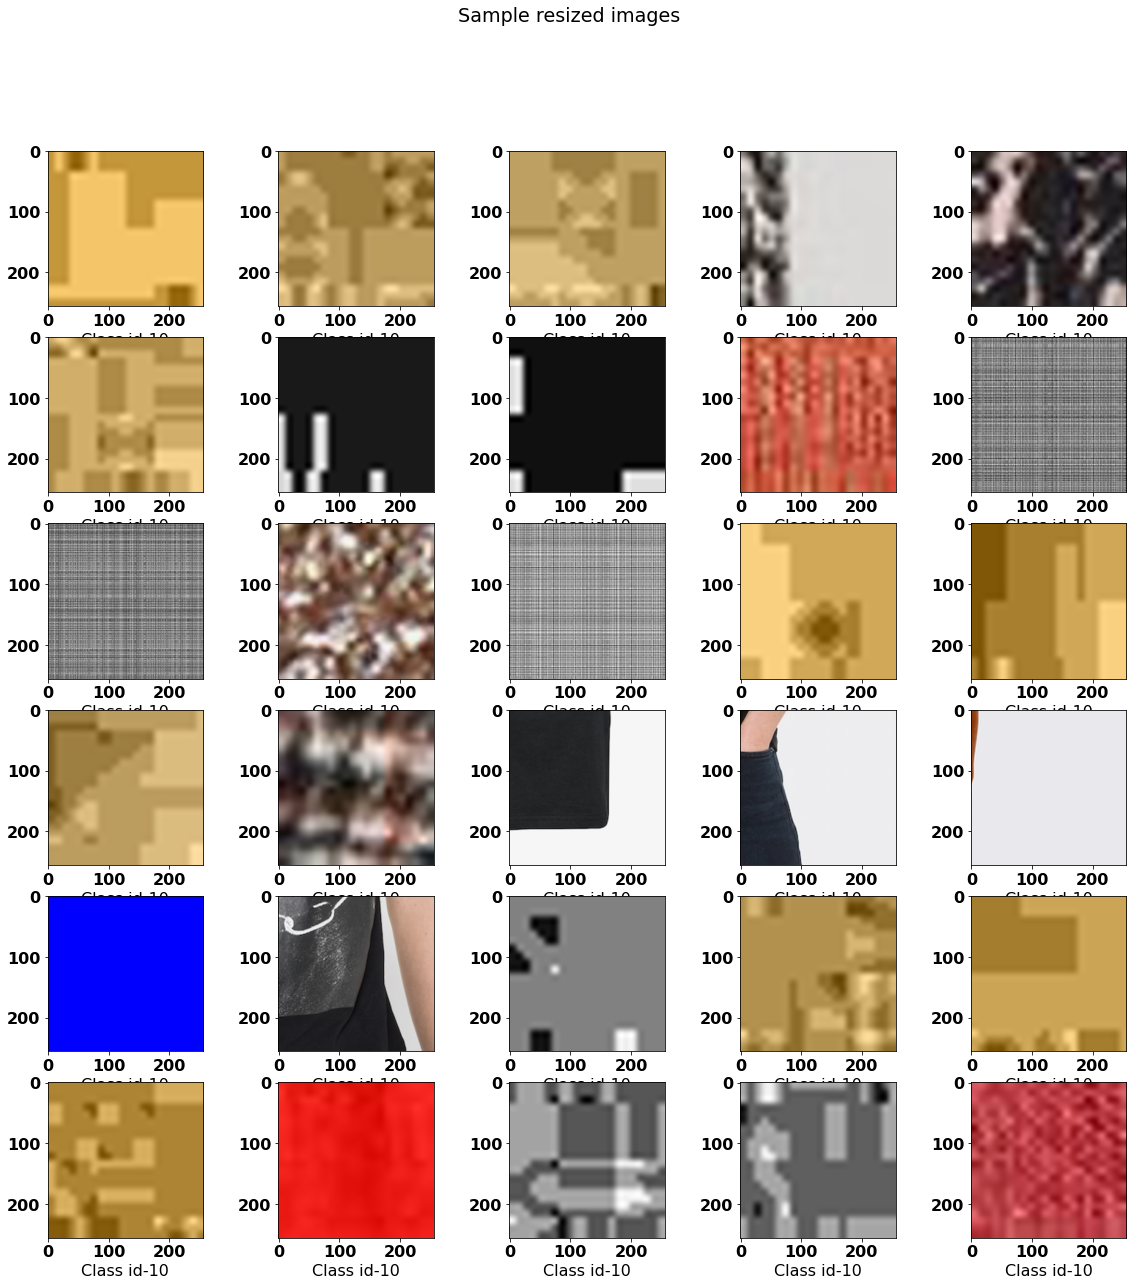

In [170]:
# plot 30 sample images
fig = plt.figure(figsize=(20,20))
fig.suptitle('Sample resized images')
for i in range(30):
    fig.add_subplot(6,5,i+1)
    plt.imshow(img_list[i])
    plt.xlabel(f'Class id-{labels_list[i]}')

### Convert train image and labels to numpy array

In [175]:
img_array = np.array(img_list, dtype = np.float32)
label_array = np.array(labels_list, dtype = np.int32)

print(f'Dataset shape {img_array.shape, label_array.shape}')
print(f'Dataset dtype {img_array.dtype, label_array.dtype}')

Dataset shape ((2850, 256, 256, 3), (2850,))
Dataset dtype (dtype('float32'), dtype('int32'))


In [176]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    new_img
    return new_img

# image aug function for the dataset having the specified class index
def img_aug(dataset,label, class_idx = 0):
    
    # fetch the index of the given class idx
    idx_list = [i for i,j in enumerate(label) if j==class_idx]

    # define augmentor objects for auto_contrast, flip with prob=1
    auto_contrast = iaa.pillike.Autocontrast()
    # auto-brightness
    auto_brightness = iaa.imgcorruptlike.Brightness()
    # auto-sharpness
    sharpness = iaa.pillike.EnhanceSharpness()
    # auto-rotate
    rotate = iaa.Rotate(rotate = (-10,10), order=1)
    eq = iaa.pillike.Equalize()
    ec = iaa.pillike.EnhanceColor()
    img_list = list(dataset)

    # augmented images list initialized with dataset
    aug_list = img_list
    # augmented label list initiallized with dataset
    aug_label_list = list(label)
  
    for idx in idx_list:
        img = img_list[idx]
    
        # auto contrast
        img_con = convert(img,0,255,np.uint8)
        img_con = auto_contrast.augment_image(img_con)
        img_con = convert(img_con,0,1,np.float32)
        aug_list.append(img_con)
        aug_label_list.append(class_idx)

        # auto-brightness
        img_b = convert(img,0,255,np.uint8)
        img_b = auto_brightness.augment_image(img_b)
        img_b = convert(img_b,0,1,np.float32)
        aug_list.append(img_b)
        aug_label_list.append(class_idx)

        # auto-sharpness
        img_s = convert(img,0,255,np.uint8)
        img_s = sharpness.augment_image(img_s)
        img_s = convert(img_s,0,1,np.float32)
        aug_list.append(img_s)
        aug_label_list.append(class_idx)

        # auto-equalize
        img_eq = convert(img,0,255,np.uint8)
        img_eq = eq.augment_image(img_eq)
        img_eq = convert(img_eq,0,1,np.float32)
        aug_list.append(img_eq)
        aug_label_list.append(class_idx)

        # auto-enhance color
        img_ec = convert(img,0,255,np.uint8)
        img_ec = ec.augment_image(img_ec)
        img_ec = convert(img_ec,0,1,np.float32)
        aug_list.append(img_ec)
        aug_label_list.append(class_idx)

        # auto-rotate
        img_r = convert(img,0,255,np.uint8)
        img_r = rotate.augment_image(img_r)
        img_r = convert(img_r,0,1,np.float32)
        aug_list.append(img_r)
        aug_label_list.append(class_idx)

        # auto contrast
        img_con = convert(img_r,0,255,np.uint8)
        img_con = auto_contrast.augment_image(img_con)
        img_con = convert(img_con,0,1,np.float32)
        aug_list.append(img_con)
        aug_label_list.append(class_idx)

        # auto-brightness
        img_b = convert(img_r,0,255,np.uint8)
        img_b = auto_brightness.augment_image(img_b)
        img_b = convert(img_b,0,1,np.float32)
        aug_list.append(img_b)
        aug_label_list.append(class_idx)

        # auto-sharpness
        img_s = convert(img_r,0,255,np.uint8)
        img_s = sharpness.augment_image(img_s)
        img_s = convert(img_s,0,1,np.float32)
        aug_list.append(img_s)
        aug_label_list.append(class_idx)

        # auto-equalize
        img_eq = convert(img_r,0,255,np.uint8)
        img_eq = eq.augment_image(img_eq)
        img_eq = convert(img_eq,0,1,np.float32)
        aug_list.append(img_eq)
        aug_label_list.append(class_idx)

        # auto-enhance color
        img_ec = convert(img_r,0,255,np.uint8)
        img_ec = ec.augment_image(img_ec)
        img_ec = convert(img_ec,0,1,np.float32)
        aug_list.append(img_ec)
        aug_label_list.append(class_idx)

    aug_img_array = np.array(aug_list, dtype=np.float32)
    # normalize the values between 0 and 1
    aug_img_array = aug_img_array - aug_img_array.min()
    aug_label_list_array = np.array(aug_label_list, dtype=np.int32) 
  
    assert aug_img_array.shape[0] == aug_label_list_array.shape[0]
  
    return aug_img_array, aug_label_list_array

### Apply Data Augmentation

In [187]:
!pip install imagecorruptions

In [ ]:
# obtain augmented image and labels pair for all the classes
class_labels = [i for i in np.unique(label_array)]
aug_img, aug_label = img_aug(img_array, label_array, class_idx=class_labels[0])
for cls in class_labels:
    if cls==0:
        aug_img, aug_label = img_aug(img_array, label_array, class_idx=cls)
    else:
        aug_img, aug_label = img_aug(aug_img, aug_label, class_idx=cls)

In [ ]:
print(f'Augmented Dataset shape {aug_img.shape, aug_label.shape}')
print(f'Augmented dtype {aug_img.dtype, aug_label.dtype}')

In [ ]:
### Visualize augmented samples

In [ ]:
# plot 30 sample images
fig = plt.figure(figsize=(20,20))
fig.suptitle('Sample augmented images')
for i in range(33):
    fig.add_subplot(7,5,i+1)
    plt.imshow(aug_img[300+i])
    plt.xlabel(f'Class id-{aug_label[300+i]}')

In [ ]:
train_img, valid_main_img, train_label, valid_main_label = train_test_split(aug_img,
                                                                            aug_label,stratify = aug_label,
                                                                            test_size = 0.1665,shuffle = True,
                                                                            random_state = 42) 

valid_img, test_img, valid_label, test_label = train_test_split(valid_main_img,
                                                                valid_main_label,stratify = valid_main_label,
                                                                test_size = 0.5,shuffle = True,random_state = 42) 

In [ ]:
print(f'Train set dimension and datatype {train_img.shape, train_img.dtype, train_label.shape, train_label.dtype}')
print(f'Validation set dimension {valid_img.shape, valid_img.dtype, valid_label.shape, valid_label.dtype}')
print(f'Test set dimension and datatype {test_img.shape, test_img.dtype, test_label.shape, test_label.dtype}')

## Model Building

In [ ]:
def Product_matching_model_v_1():
    conv_base = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3),
        pooling='avg'
        )
  
    model = Sequential()
    model.add(conv_base)
    model.add(Dense(100, activation='softmax'))

    return model

In [ ]:
model = Product_matching_model_v_1()

In [ ]:
model.summary()

### Define fine-tuning parameters

In [ ]:
# here we are freezing the base model
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False

conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

### Model Training

In [ ]:
# plot accuracy urve
def plot_accuracy_curves(history):  
    acc = history.history['acc']
    val_acc = history.history['val_acc']
 
    epochs = range(1, len(acc) + 1)
 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

# plot loss curve
def plot_loss_curves(history): 

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
def plot_curves(history): 
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plot_accuracy_curves(history)
    plt.subplot(1,2,2)
    plot_loss_curves(history)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [ ]:
mc_filepath = os.path.join('//Images//', 'product_best_model.h5')
mcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=mc_filepath, monitor='val_loss',verbose = 1, save_best_only=True, save_freq=375, mode ='min')

In [ ]:
history = model.fit(x = train_img, y = train_label, batch_size= 16, epochs = 10, verbose=1, validation_data=(valid_img, valid_label), callbacks=[mcheckpoint])

In [ ]:
model.save('/content/drive/MyDrive/product_best_model.h5')
plot_curves(history)

## Evaluate the model training

In [ ]:
model.evaluate(test_img, test_label)

In [ ]:
test_pred = model.predict(test_img)
test_pred = np.argmax(test_pred, 1)
print(test_pred)

### classification report and confusion matrix

In [ ]:
print(f'Classification report {metrics.classification_report(test_label, test_pred)}')

fig_cm = plt.figure(figsize=(20,5))
fig_cm.suptitle('Confusion Matrix')
sns.heatmap(confusion_matrix(test_label, test_pred))